In [5]:
import duckdb
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkb, wkt
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import contextily as cx

# PySAL pieces
from pysal.explore import esda
from libpysal import weights
from splot import esda as esdaplot

import leafmap

print("Ready!")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Ready!


# 1) Parameters
Tweak these if you want a different theme, bbox, or file path.

In [6]:
# Overture "places" theme: select categories here
CATEGORIES = ('pizza_restaurant','bagel_restaurant','coffee_shop')

# Simple bbox filter (these were in your original cell)
# xmin, xmax, ymin, ymax
BBOX_XMIN, BBOX_XMAX = -75, -73
BBOX_YMIN, BBOX_YMAX = 40, 41

# Local polygons file (from your original notebook)
BLOCKS_GEOJSON = "data/2020 Census Blocks_20250805.geojson"

# KNN neighbors for LISA
KNN_K = 8

# 2) Load polygons (Census Blocks) and ensure valid geometry
We’ll keep this part in GeoPandas so we can do plotting and compute areas in projected CRS.

In [8]:
blocks = gpd.read_file(BLOCKS_GEOJSON)

# If your file already has a useful ID column, set it here (try a few common names)
ID_COL_CANDIDATES = ["GEOID20", "GEOID", "geoid", "OBJECTID", "id", "Id"]
id_col = None
for c in ID_COL_CANDIDATES:
    if c in blocks.columns:
        id_col = c
        break

if id_col is None:
    # fallback: create a sequential ID
    id_col = "_block_id"
    blocks[id_col] = np.arange(len(blocks))

# Fix CRS if needed; we’ll work in Web Mercator (meters) for area/basemap, but keep a copy in WGS84 for Leafmap
if blocks.crs is None:
    # Guess WGS84; change if needed
    blocks = blocks.set_crs(4326)

blocks_3857 = blocks.to_crs(3857)
blocks_4326 = blocks.to_crs(4326)

# Compute polygon area in km² (for density)
blocks_3857["area_km2"] = blocks_3857.geometry.area / 1_000_000

print("Blocks:", len(blocks_3857), "CRS:", blocks_3857.crs, "ID column:", id_col)
blocks_3857[[id_col, "area_km2"]].head()


Blocks: 37589 CRS: EPSG:3857 ID column: geoid


,geoid,area_km2
0,360610001001000,0.194613
1,360610001001001,0.103543
2,360610002011000,0.020926
3,360610002011001,0.022558
4,360610002012000,0.042619


# 3) Use DuckDB to pull Overture “shops” points from S3
We’ll filter by category and the bbox (min corner check aligns with your original code), then return a tidy shops DataFrame with WKB geometry.

In [15]:
con = duckdb.connect()
con.execute('INSTALL spatial')
con.execute('LOAD spatial')

query = f"""
WITH shops AS (
  SELECT
    id,
    names.primary AS name,
    confidence AS confidence,
    CAST(socials AS JSON) AS socials,
    geometry
  FROM
    read_parquet(
      's3://overturemaps-us-west-2/release/2025-07-23.0/theme=places/type=place/*',
      filename=true, hive_partitioning=1
    )
  WHERE
    categories.primary IN {CATEGORIES}
    AND bbox.xmin BETWEEN {BBOX_XMIN} AND {BBOX_XMAX}
    AND bbox.ymin BETWEEN {BBOX_YMIN} AND {BBOX_YMAX}
)
SELECT
  id,
  name,
  confidence,
  socials,
  ST_AsText(geometry) as geometry  -- this is WKT or WKB depending on the parquet schema; DuckDB ST functions can adapt
FROM shops
"""

shops_df = con.execute(query).df()
shops_df = gpd.GeoDataFrame(shops_df, geometry=shops_df['geometry'].apply(wkt.loads))
print("Raw shops rows:", len(shops_df))
shops_df.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Raw shops rows: 9899


,id,name,confidence,socials,geometry
0,75a62453-3eac-4a70-8435-ab057ac6fa8a,Tony Sopranos Pizza & Ristorante,0.995064,"[""https://www.facebook.com/154687674608968""]",POINT (-74.98516 40.00008)
1,2ad2fe9e-f4cd-49e0-a259-bac0b8962529,Pats Select Cinnaminson,0.978538,"[""https://www.facebook.com/102500822403190""]",POINT (-74.97249 40.00706)
2,ec8db429-b0c8-409a-a6a9-b0f50756e519,Bella Pizza Cafe,0.995064,"[""https://www.facebook.com/100996899356916""]",POINT (-74.97306 40.03168)
3,ffa60347-61ce-4d81-897a-dd6626a28968,Starbucks,0.995064,"[""https://www.facebook.com/376237326311110""]",POINT (-74.98727 40.00018)
4,33c04ceb-9631-4574-a3a9-63da5f265246,Tim Hortons,0.770000,None,POINT (-74.97135 40.00856)


# 4) Convert shops to GeoDataFrame in Web Mercator (EPSG:3857)
We’ll be explicit converting geometry to shapely and set CRS.

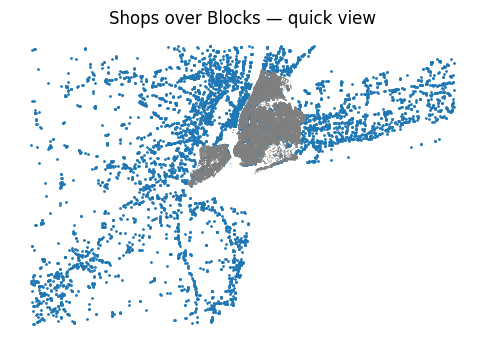

In [16]:
# Try to parse geometry as WKT first; if that fails, try WKB
def parse_geom(val):
    if isinstance(val, (bytes, bytearray)):
        return wkb.loads(val)
    if isinstance(val, str):
        return wkt.loads(val)
    # already shapely? return as-is
    return val

shops_geom = shops_df["geometry"].apply(parse_geom)
shops = gpd.GeoDataFrame(shops_df.drop(columns=["geometry"]), geometry=shops_geom, crs=4326)
shops_3857 = shops.to_crs(3857)

# Quick plot of points to sanity check
ax = blocks_3857.boundary.plot(figsize=(6,6), linewidth=0.3, color="0.5")
shops_3857.plot(ax=ax, markersize=1)
ax.set_axis_off(); ax.set_title("Shops over Blocks — quick view")
plt.show()


# 5) Aggregate: count shops per block (LEFT JOIN behavior)
We ensure all polygons are kept even if no shops fall inside (zero counts). We’ll do the spatial join in GeoPandas for clarity; you could also do it in DuckDB with ST_Contains if preferred.

In [17]:
# Spatial join: which block contains each shop?
# Use a robust predicate (within or contains). Here: point-in-polygon using sjoin
joined = gpd.sjoin(
    shops_3857[["id", "geometry"]],
    blocks_3857[[id_col, "geometry"]],
    how="left",
    predicate="within"
)

# Count shops per block
counts = (
    joined
    .groupby(id_col, dropna=False)
    .size()
    .rename("shops_count")
    .reset_index()
)

# Merge counts back to blocks; fill NaN with 0
blocks_agg = blocks_3857.merge(counts, on=id_col, how="left")
blocks_agg["shops_count"] = blocks_agg["shops_count"].fillna(0).astype(int)

# Density per km² (avoid divide by zero)
blocks_agg["shops_density"] = np.where(
    blocks_agg["area_km2"] > 0,
    blocks_agg["shops_count"] / blocks_agg["area_km2"],
    0.0
)

blocks_agg[[id_col, "shops_count", "area_km2", "shops_density"]].head()


,geoid,shops_count,area_km2,shops_density
0,360610001001000,0,0.194613,0.0
1,360610001001001,0,0.103543,0.0
2,360610002011000,0,0.020926,0.0
3,360610002011001,0,0.022558,0.0
4,360610002012000,0,0.042619,0.0


# 6) Quick choropleth — shops density


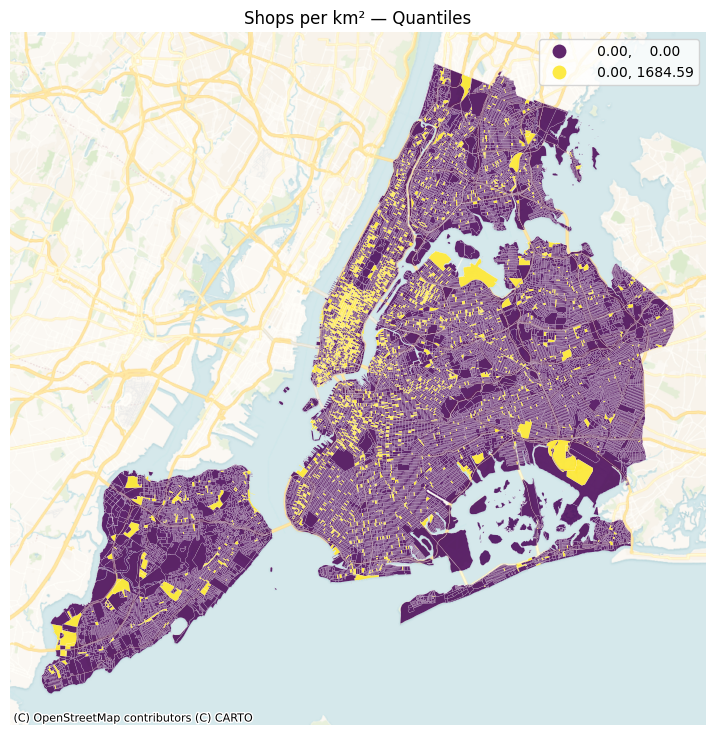

In [18]:
fig, ax = plt.subplots(figsize=(9,9))
blocks_agg.plot(
    column="shops_density", scheme="quantiles", k=5, legend=True,
    edgecolor="white", linewidth=0.1, alpha=0.85, ax=ax
)
cx.add_basemap(ax, crs=blocks_agg.crs, source=cx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off(); ax.set_title("Shops per km² — Quantiles")
plt.show()


# 7) Build spatial weights & Moran scatter (intuition)
We’ll use KNN(k=8) on block centroids (common when polygons vary in size). You can toggle to Queen contiguity if you prefer adjacency-based neighborhoods.


### Choosing a Spatial Weights Type

Spatial weights define **"who is neighbors with whom"** in your dataset, and this choice shapes every local statistic.

**Common Types:**

* **Contiguity (Queen / Rook)**
  Neighbors share a border (Queen includes corners, Rook only edges).
  *Best for*: polygon data where adjacency matters (administrative units, parcels).
  *Pros*: Captures geographic boundaries; easy to explain.
  *Cons*: Can be misleading if polygons vary greatly in size or shape.

* **K-Nearest Neighbors (KNN)**
  Each feature connects to its *k* closest neighbors by centroid distance.
  *Best for*: irregular polygons, varying shapes/sizes, point datasets.
  *Pros*: Ensures each feature has the same number of neighbors; avoids isolated polygons.
  *Cons*: “Distance” is purely geometric; ignores shared borders.

* **Distance Bands**
  Neighbors are all features within a given distance threshold.
  *Best for*: point data or continuous surfaces where proximity matters more than adjacency.
  *Pros*: Mimics spatial decay; easy to interpret.
  *Cons*: Choosing the threshold can be tricky.

**Why KNN here:**
Our Census Blocks vary in size and shape, and some may be isolated in the filtered area. KNN guarantees each block has neighbors to compare against, avoiding bias from missing or edge polygons. It’s well-suited for density measures like shops per km² where physical proximity is more relevant than shared boundaries.


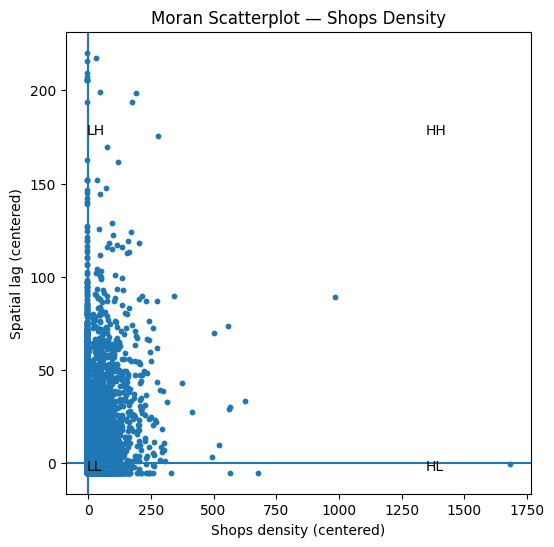

In [23]:
# Use centroids for KNN
centroids = blocks_agg.geometry.centroid
gdf_centroids = gpd.GeoDataFrame(blocks_agg[[id_col]].copy(), geometry=centroids, crs=blocks_agg.crs)

# KNN weights
w_knn = weights.distance.KNN.from_dataframe(gdf_centroids, k=KNN_K)

# w_q = weights.Queen.from_dataframe(gdf_centroids, use_index=False, silence_warnings=True, ids=gdf_centroids['geoid'])

w_knn.transform = "R"

# Make a centered variable for scatter
y = blocks_agg["shops_density"].astype(float)
y_c = y - y.mean()
lag_y_c = weights.lag_spatial(w_knn, y_c)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_c, lag_y_c, s=10)
ax.axvline(0); ax.axhline(0)
ax.set_xlabel("Shops density (centered)")
ax.set_ylabel("Spatial lag (centered)")
ax.set_title("Moran Scatterplot — Shops Density")
ax.text(y_c.max()*0.8,  lag_y_c.max()*0.8, "HH")
ax.text(y_c.min()*0.8,  lag_y_c.max()*0.8, "LH")
ax.text(y_c.min()*0.8,  lag_y_c.min()*0.8, "LL")
ax.text(y_c.max()*0.8,  lag_y_c.min()*0.8, "HL")
plt.show()

## Quick Visual: Queen vs KNN
Left (Queen): connections exist only when polygons touch (edge or corner).
Right (KNN): each polygon connects to its k nearest centroids (here, k=4), even if they don’t share a border.

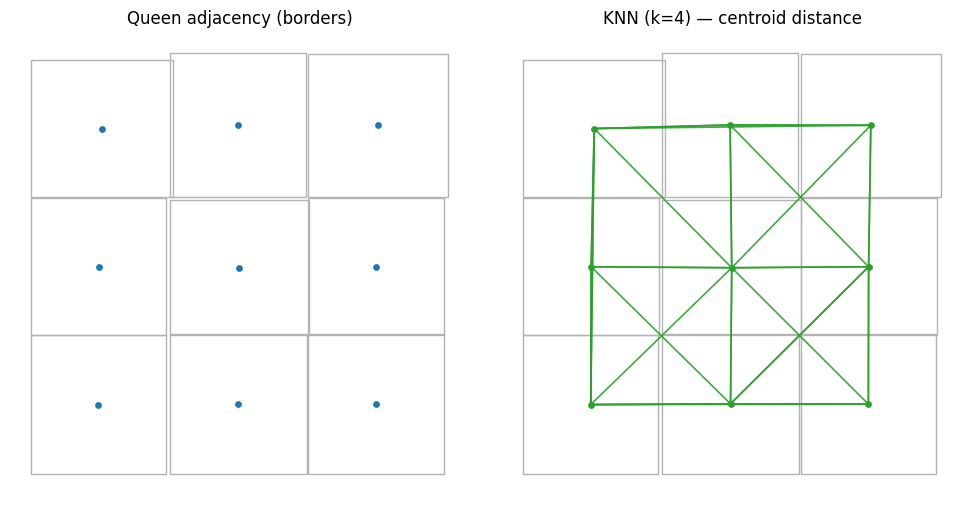

In [25]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
from libpysal import weights
import numpy as np

# --- make a small, slightly irregular 3x3 grid of polygons ---
cells = []
size = 1000
for r in range(3):
    for c in range(3):
        x0, y0 = c*size, r*size
        # add a tiny jitter to make shapes/centroids a bit irregular
        jx, jy = (np.random.rand()-0.5)*80, (np.random.rand()-0.5)*80
        poly = Polygon([(x0, y0),
                        (x0+size+jx, y0),
                        (x0+size+jx, y0+size+jy),
                        (x0, y0+size+jy)])
        cells.append(poly)

gdf = gpd.GeoDataFrame({"id": range(len(cells))}, geometry=cells, crs=3857)
cent = gdf.geometry.centroid
cent_gdf = gpd.GeoDataFrame({"id": gdf["id"]}, geometry=cent, crs=gdf.crs)

# --- Queen contiguity (left) ---
wq = weights.Queen.from_dataframe(gdf)

# --- KNN on centroids (right) ---
k = 4
wk = weights.distance.KNN.from_dataframe(cent_gdf, k=k)

# --- plotting helpers ---
def draw_connections(ax, pairs, pts, color="k", alpha=0.8, lw=1.0):
    for i, js in pairs.items():
        p0 = pts.iloc[i].coords[0]
        for j in js:
            p1 = pts.iloc[j].coords[0]
            ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=color, alpha=alpha, lw=lw)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: Queen (border-based)
gdf.plot(ax=axes[0], facecolor="none", edgecolor="0.7", linewidth=1.0)
draw_connections(axes[0], wq.neighbors, cent, color="tab:blue", alpha=0.9, lw=1.2)
cent_gdf.plot(ax=axes[0], markersize=15, color="tab:blue")
axes[0].set_title("Queen adjacency (borders)")
axes[0].set_axis_off()

# Right: KNN (distance-based)
gdf.plot(ax=axes[1], facecolor="none", edgecolor="0.7", linewidth=1.0)
draw_connections(axes[1], wk.neighbors, cent, color="tab:green", alpha=0.9, lw=1.2)
cent_gdf.plot(ax=axes[1], markersize=15, color="tab:green")
axes[1].set_title(f"KNN (k={k}) — centroid distance")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# 8) Local Moran’s I (LISA) — clusters & outliers
- **Positive local I** ⇒ similarity (HH/LL)
- **Negative local I** ⇒ dissimilarity (HL/LH)
We’ll use p < 0.05 for significance.

### Understanding Local Moran’s I (LISA) — Clusters & Outliers

Local Moran’s I is like a **spatial “neighborhood gossip” score**: it tells you if a place looks like its neighbors, or if it’s the odd one out.

* **The “I” value**:
  Measures how similar a feature’s value is to the values of its neighbors.

  * **Positive I** → the feature is **similar** to its neighbors (high next to high, or low next to low).
  * **Negative I** → the feature is **different** from its neighbors (high next to low, or low next to high).

* **Quadrants in the LISA plot**:

  1. **HH (High-High)** → High value surrounded by high values — **hot spot**.
  2. **LL (Low-Low)** → Low value surrounded by low values — **cold spot**.
  3. **LH (Low-High)** → Low value surrounded by high values — **potential outlier**.
  4. **HL (High-Low)** → High value surrounded by low values — **potential outlier**.

* **Significance (p < 0.05)**:
  Just because a feature has a positive or negative I doesn’t mean it’s meaningful.
  We shuffle the data thousands of times (permutation test) and see if the observed pattern happens less than 5% of the time by chance.
  If it does, we call it **statistically significant**.

**How to read the charts below:**

1. **Local Moran’s I map** — shows the I value for each polygon. Positive values = similarity, negative = dissimilarity.
2. **Quadrants (all)** — color-codes HH, LL, LH, HL for every feature, ignoring significance.
3. **Significance map** — highlights only where p < 0.05, regardless of cluster type.
4. **Cluster map (p < 0.05)** — combines quadrant and significance, so you see *where* clusters/outliers are both present **and** statistically meaningful.

**Why this matters here:**
We’re studying shop density patterns. LISA helps us pinpoint not just “are shops clustered?” but **exactly where those clusters are**, and whether they’re hot spots (dense areas) or cold spots (sparse areas), plus where unexpected outliers live.


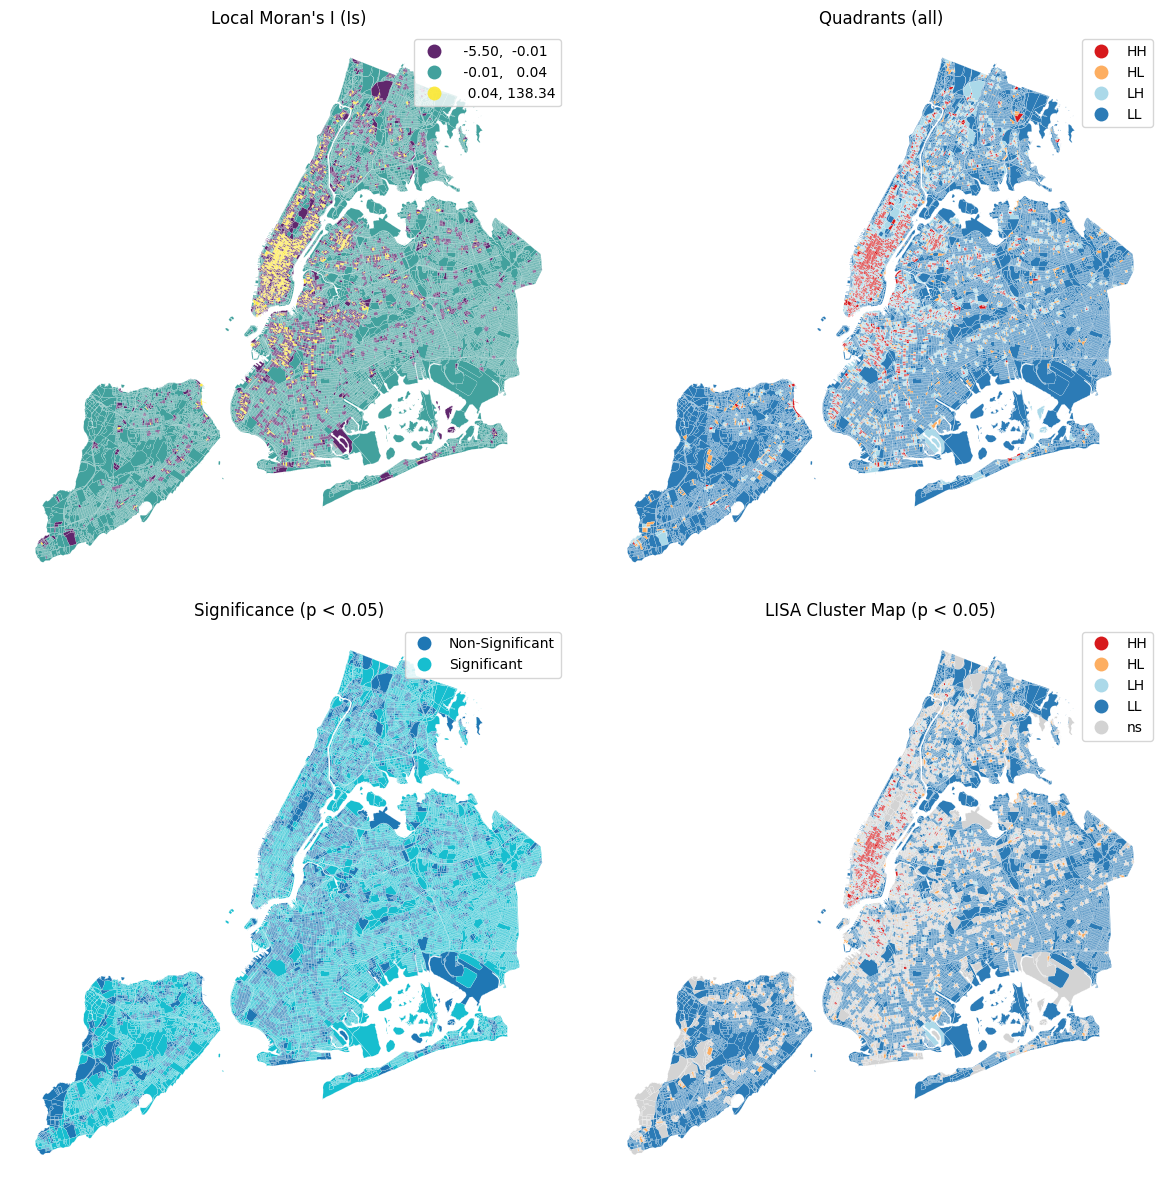

lisa_label
LL                 23033
Non-Significant    11476
LH                  1477
HH                   849
HL                   754
Name: count, dtype: int64

In [24]:
# Compute LISA on shops_density
lisa = esda.moran.Moran_Local(y.values, w_knn)

# Mask by significance
sig = 1 * (lisa.p_sim < 0.05)
spots = lisa.q * sig
label_map = {0:"Non-Significant", 1:"HH", 2:"LH", 3:"LL", 4:"HL"}

blocks_agg["I_local"] = lisa.Is
blocks_agg["p_sim"] = lisa.p_sim
blocks_agg["lisa_label"] = pd.Series(spots, index=blocks_agg.index).map(label_map)

# 2x2 visualization: Is, quadrants, significance, cluster map
fig, axs = plt.subplots(2,2, figsize=(12,12))

# 1) Local Is
blocks_agg.assign(Is=lisa.Is).plot(
    column="Is", scheme="quantiles", k=5, legend=True,
    edgecolor="white", linewidth=0.1, alpha=0.85, ax=axs[0,0]
)
axs[0,0].set_axis_off(); axs[0,0].set_title("Local Moran's I (Is)")

# 2) Quadrants only (no significance filter)
esdaplot.lisa_cluster(lisa, blocks_agg, p=1, ax=axs[0,1])
axs[0,1].set_axis_off(); axs[0,1].set_title("Quadrants (all)")

# 3) Significance-only map
sig_lab = pd.Series(sig, index=blocks_agg.index).map({1:"Significant",0:"Non-Significant"})
blocks_agg.assign(sig_label=sig_lab).plot(
    column="sig_label", categorical=True, legend=True,
    edgecolor="white", linewidth=0.1, ax=axs[1,0]
)
axs[1,0].set_axis_off(); axs[1,0].set_title("Significance (p < 0.05)")

# 4) Cluster map (quadrant + significance)
esdaplot.lisa_cluster(lisa, blocks_agg, p=0.05, ax=axs[1,1])
axs[1,1].set_axis_off(); axs[1,1].set_title("LISA Cluster Map (p < 0.05)")

plt.tight_layout(); plt.show()

# Quick counts
blocks_agg["lisa_label"].value_counts(dropna=False)


# 9) Getis–Ord Gi and Gi* — hotspot vs coldspot
Gi* includes the focal site value; Gi excludes it. They don’t flag outliers (HL/LH); they focus on hot/cold clustering.

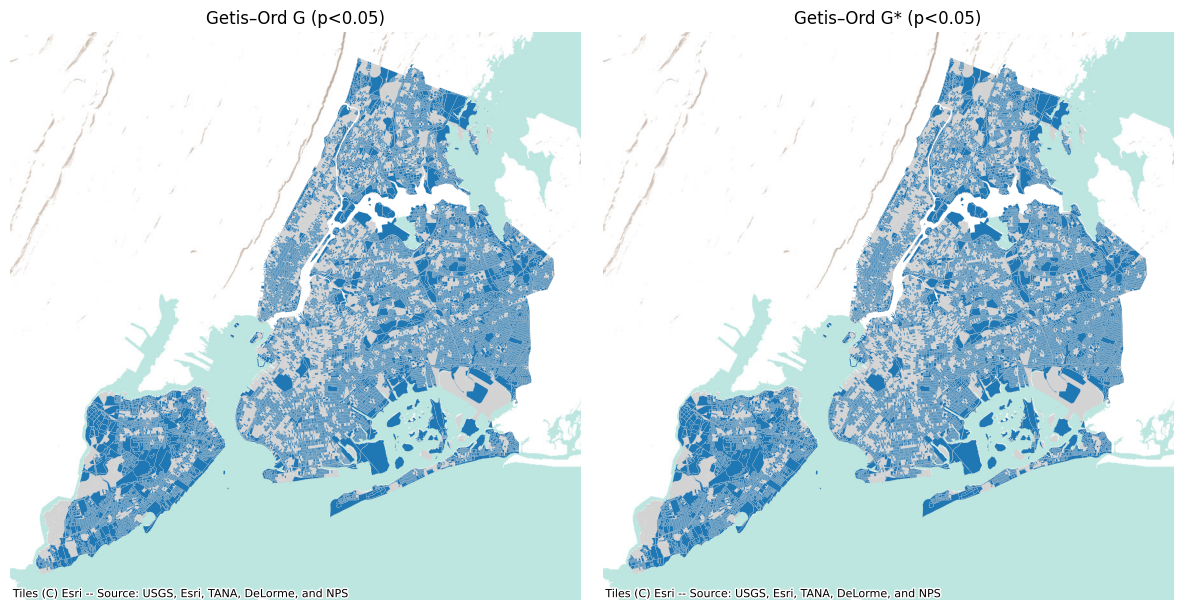

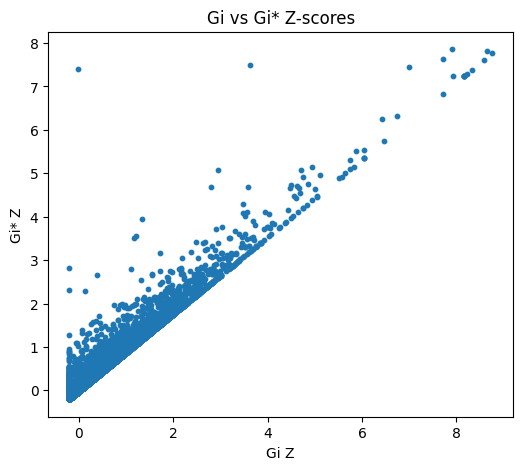

In [26]:
go_i     = esda.getisord.G_Local(y.values, w_knn, star=False)
go_i_star= esda.getisord.G_Local(y.values, w_knn, star=True)

def plot_gmap(g, gdf, title, ax):
    sig = g.p_sim < 0.05
    ec = "0.8"
    gdf.loc[~sig, "geometry"].plot(ax=ax, edgecolor=ec, linewidth=0.1, color="lightgrey")
    gdf.loc[(g.Zs > 0) & sig, "geometry"].plot(ax=ax, edgecolor=ec, linewidth=0.1)  # hot
    gdf.loc[(g.Zs < 0) & sig, "geometry"].plot(ax=ax, edgecolor=ec, linewidth=0.1)  # cold
    cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.Esri.WorldTerrain)
    ax.set_axis_off(); ax.set_title(title)

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_gmap(go_i,      blocks_agg, "Getis–Ord G (p<0.05)",  axs[0])
plot_gmap(go_i_star, blocks_agg, "Getis–Ord G* (p<0.05)", axs[1])
plt.tight_layout(); plt.show()

# Compare Z-scores
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(go_i.Zs, go_i_star.Zs, s=10)
ax.set_xlabel("Gi Z"); ax.set_ylabel("Gi* Z"); ax.set_title("Gi vs Gi* Z-scores")
plt.show()


# 10) Optional — Interactive peek at HH clusters (Leafmap)

In [28]:
try:
    m = leafmap.Map(center=[(BBOX_YMIN+BBOX_YMAX)/2, (BBOX_XMIN+BBOX_XMAX)/2], zoom=9)
    hh = blocks_agg.to_crs(4326).loc[blocks_agg["lisa_label"]=="HH", [id_col, "lisa_label","shops_density","geometry"]]
    m.add_gdf(hh, layer_name="HH — high density clusters")
    m
except Exception as e:
    print("Leafmap skipped:", e)

In [29]:
m

Map(center=[40.5, -74.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [38]:
# ✅ Final Proof of Completion
import hashlib

proof_string = f"{len(blocks_agg)} features | Moran I mean = {round(blocks_agg['I_local'].mean(), 4)} | Gi* max z = {round(blocks_agg['p_sim'].max(), 2)}"
proof_hash = hashlib.md5(proof_string.encode()).hexdigest()

with open("badge_proof.txt", "w") as f:
    f.write(proof_hash)

print("✅ Your badge proof code:", proof_hash)

✅ Your badge proof code: d2856c8a68a18fbe15e26ef355605fcd
